<a href="https://www.kaggle.com/code/purushothamanpj/fingertype-densenet-balanced?scriptVersionId=263124624" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Config
img_size = 224
batch_size = 16
num_classes = 20  # Male/Female × Left/Right × 5 fingers


2025-09-21 09:57:20.210393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758448640.391868      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758448640.442989      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Dataset paths (change according to your Kaggle dataset)
train_paths = [
    "/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy",
    "/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium",
    "/kaggle/input/socofing/SOCOFing/Altered/Altered-Hard"
]

test_paths = ["/kaggle/input/socofing/SOCOFing/Real"]


In [3]:
#Check for the number of files
for folder in train_paths:
    print(folder, "contains", len(os.listdir(folder)), "files")


/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy contains 17931 files
/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium contains 17067 files
/kaggle/input/socofing/SOCOFing/Altered/Altered-Hard contains 14272 files


In [4]:
gender_map = {"m":0, "f":1}   # Male/Female
hand_map = {"left":0, "right":1}
finger_map = {"thumb":0, "index":1, "middle":2, "ring":3, "little":4}

def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    try:
        subject_id, etc = filename.split('__')
    except:
        raise ValueError(f"Unexpected filename format: {filename}")
    
    parts = etc.lower().split('_')
    
    # Find gender
    gender = next((p for p in parts if p in gender_map), None)
    hand = next((p for p in parts if p in hand_map), None)
    finger = next((p for p in parts if p in finger_map), None)
    
    if gender is None or hand is None or finger is None:
        raise ValueError(f"Cannot parse gender/hand/finger from: {filename}")
    
    # 20 classes: gender*10 + hand*5 + finger
    class_idx = gender_map[gender]*10 + hand_map[hand]*5 + finger_map[finger]
    
    return np.array([subject_id, class_idx, hand, gender], dtype=object)


In [5]:
# Data Generator
class FingerDataGenerator(Sequence):
    def __init__(self, img_paths, labels, batch_size=32, img_size=224, num_classes=20, shuffle=True):
        self.img_paths = img_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.img_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        batch_paths = [self.img_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        X = np.zeros((len(batch_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_paths), self.num_classes), dtype=np.float32)

        for i, path in enumerate(batch_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = np.stack([img]*3, axis=-1) / 255.0
            X[i] = img
            y[i] = to_categorical(batch_labels[i], num_classes=self.num_classes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [6]:
# Cell 2: Collect paths & labels, split, and create generators

def get_paths_and_labels(folder_paths, train=True):
    img_paths = []
    labels = []
    for folder in folder_paths:
        for img in os.listdir(folder):
            try:
                path = os.path.join(folder, img)
                label = extract_label(path, train=train)[1]
                img_paths.append(path)
                labels.append(label)
            except Exception as e:
                print(f"Skipped {img}: {e}")
    return img_paths, labels

# Collect paths and labels
X_train_paths, y_train = get_paths_and_labels(train_paths, train=True)
X_test_paths, y_test = get_paths_and_labels(test_paths, train=False)

# Split train into train + validation (stratify to keep class balance)
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    X_train_paths, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Create generators
train_generator = FingerDataGenerator(X_train_paths, y_train, batch_size, img_size, num_classes)
val_generator = FingerDataGenerator(X_val_paths, y_val, batch_size, img_size, num_classes, shuffle=False)
test_generator = FingerDataGenerator(X_test_paths, y_test, batch_size, img_size, num_classes, shuffle=False)

# Print dataset sizes
print(f"Train samples: {len(X_train_paths)}")
print(f"Val samples: {len(X_val_paths)}")
print(f"Test samples: {len(X_test_paths)}")

Train samples: 39416
Val samples: 9854
Test samples: 6000


In [7]:
# Cell 6: DenseNet121 for 20-class Male/Female × Left/Right × 5 fingers
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size,img_size,3)))

# 🔹 Freeze first layers, unfreeze last 150 for fine-tuning
for layer in base_model.layers[:-150]:
    layer.trainable = False
for layer in base_model.layers[-150:]:
    layer.trainable = True

# Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  # num_classes = 20

model = Model(inputs=base_model.input, outputs=output)

# Compile with small learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 🔹 Callbacks
model_save_path = '/kaggle/working/finger_model_20class.h5'  # Save path for Kaggle
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)
]

# 🔹 Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# 🔹 Save the final model (redundant if ModelCheckpoint already saved best model)
model.save(model_save_path)
print(f"Trained model saved at: {model_save_path}")


I0000 00:00:1758448653.472781      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,572,564 (28.89 MB)

 Trainable params: 3,898,004 (14.87 MB)

 Non-trainable params: 3,674,560 (14.02 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1758448701.311036      57 service.cc:148] XLA service 0x78da88001450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758448701.311853      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758448705.998293      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2464 ━━━━━━━━━━━━━━━━━━━━ 2:12 54ms/step - accuracy: 0.0156 - loss: 4.2360       

I0000 00:00:1758448733.904401      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2464/2464 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.1920 - loss: 2.8058
Epoch 1: val_loss improved from inf to 1.74313, saving model to /kaggle/working/finger_model_20class.h5
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 569s 200ms/step - accuracy: 0.1921 - loss: 2.8056 - val_accuracy: 0.4778 - val_loss: 1.7431 - learning_rate: 1.0000e-05
Epoch 2/20
2463/2464 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4342 - loss: 1.8269
Epoch 2: val_loss improved from 1.74313 to 1.34769, saving model to /kaggle/working/finger_model_20class.h5
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 125s 51ms/step - accuracy: 0.4342 - loss: 1.8268 - val_accuracy: 0.5891 - val_loss: 1.3477 - learning_rate: 1.0000e-05
Epoch 3/20
2463/2464 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5451 - loss: 1.4481
Epoch 3: val_loss improved from 1.34769 to 1.06301, saving model to /kaggle/working/finger_model_20class.h5
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 125s 51ms/step - accuracy: 0.5451 - loss: 1.4480 - val_accuracy: 0.6689 - val_loss: 1.0630 

In [8]:
# Cell 8: Evaluate model on Train, Validation & Test sets

# Training set evaluation
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Validation set evaluation
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Test set evaluation
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


2464/2464 ━━━━━━━━━━━━━━━━━━━━ 84s 34ms/step - accuracy: 0.9998 - loss: 0.0016
Training Accuracy: 99.98%
Training Loss: 0.0017
616/616 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9883 - loss: 0.0384
Validation Accuracy: 98.79%
Validation Loss: 0.0399
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.9973 - loss: 0.0091
Test Accuracy: 99.80%
Test Loss: 0.0078


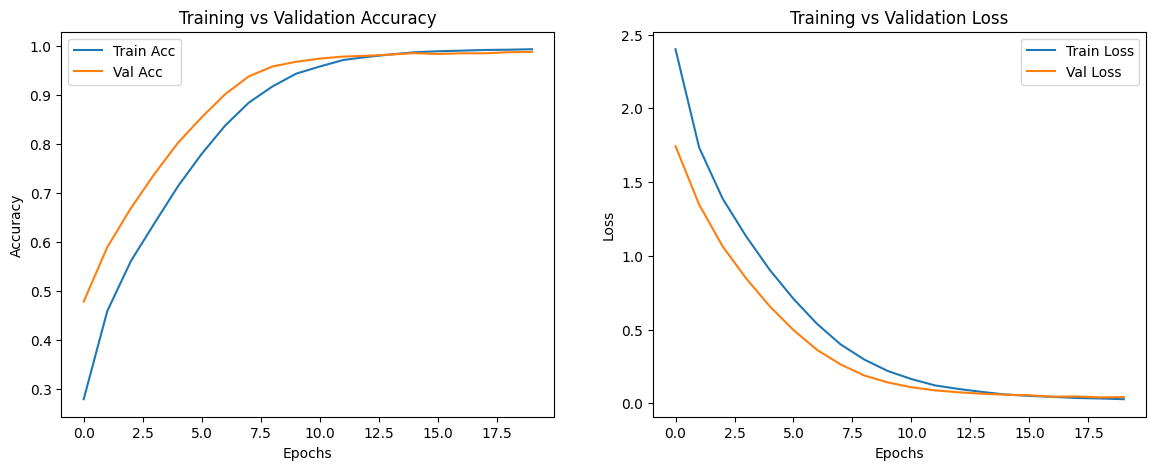

In [9]:
# Cell 9: Plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9979    1.0000    0.9990       477
           1     0.9979    1.0000    0.9990       477
           2     0.9958    1.0000    0.9979       477
           3     1.0000    0.9958    0.9979       477
           4     1.0000    0.9874    0.9937       477
           5     1.0000    1.0000    1.0000       477
           6     1.0000    1.0000    1.0000       477
           7     0.9979    0.9979    0.9979       477
           8     0.9979    1.0000    0.9990       477
           9     0.9958    0.9979    0.9969       477
          10     1.0000    1.0000    1.0000       123
          11     1.0000    1.0000    1.0000       123
          12     1.0000    1.0000    1.0000       123
          13     1.0000    0.9919    0.9959       123
          14     0.9762    1.0000    0.9880       123
          15     1.0000    1.0000    1.0000       123
          16  

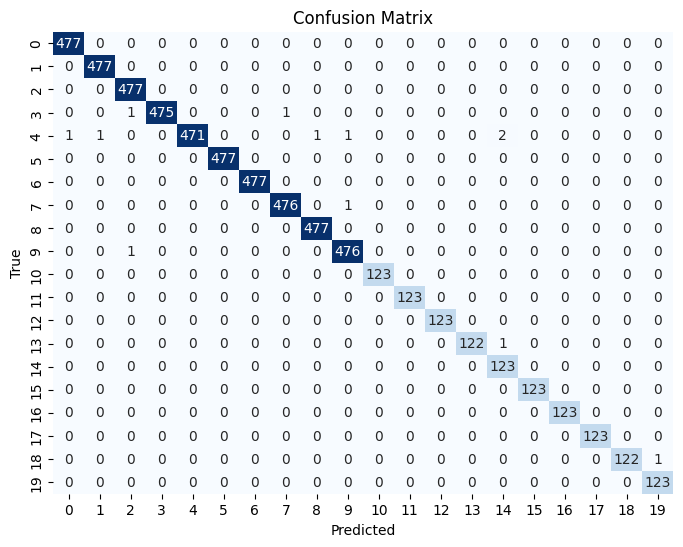

In [10]:
# Cell 10: Predictions and performance metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test set
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.labels

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
# Save the trained model
model_save_path = '/kaggle/working/finger_model_20class.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")



Model saved to /kaggle/working/finger_model_20class.h5
